<a href="https://colab.research.google.com/github/ji-hun-choi/SOTA-Study/blob/main/AlexNet_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch

import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, models, transforms


In [ ]:
import gdown
## google drive에서 압축된 dataset download
url = 'https://drive.google.com/uc?id=1DtxpOUpARxcnU4qHINz9OgiOdXiji1RZ'
fname = 'hym_data.zip'
gdown.download(url, fname, quiet=False)
!unzip hym_data.zip # test를 위한 data.zip 파일 가져오기.

Downloading...
From: https://drive.google.com/uc?id=1DtxpOUpARxcnU4qHINz9OgiOdXiji1RZ
To: /content/hym_data.zip
100%|██████████| 95.0M/95.0M [00:00<00:00, 157MB/s]


Archive:  hym_data.zip
  inflating: hym_data/val/ants/183260961_64ab754c97.jpg  
  inflating: hym_data/val/ants/desert_ant.jpg  
  inflating: hym_data/val/ants/Ant-1818.jpg  
  inflating: hym_data/val/ants/436944325_d4925a38c7.jpg  
  inflating: hym_data/val/ants/768870506_8f115d3d37.jpg  
  inflating: hym_data/val/ants/412436937_4c2378efc2.jpg  
  inflating: hym_data/val/ants/11381045_b352a47d8c.jpg  
  inflating: hym_data/val/ants/649407494_9b6bc4949f.jpg  
  inflating: hym_data/val/ants/119785936_dd428e40c3.jpg  
  inflating: hym_data/val/ants/159515240_d5981e20d1.jpg  
  inflating: hym_data/val/ants/1119630822_cd325ea21a.jpg  
  inflating: hym_data/val/ants/172772109_d0a8e15fb0.jpg  
  inflating: hym_data/val/ants/540543309_ddbb193ee5.jpg  
  inflating: hym_data/val/ants/F.pergan.28(f).jpg  
  inflating: hym_data/val/ants/2255445811_dabcdf7258.jpg  
  inflating: hym_data/val/ants/459442412_412fecf3fe.jpg  
  inflating: hym_data/val/ants/263615709_cfb28f6b8e.jpg  
  inflating: hym_d

## 데이터 불러오기

In [ ]:
ddir = '/content/hym_data'
batch_size = 64
num_workers = 4
data_transformers = {
    'train': transforms.Compose(
        [
         transforms.RandomResizedCrop(224), 
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize([0.490, 0.449, 0.411], [0.231, 0.221, 0.230])
        ]
    ),
    'val': transforms.Compose(
        [
         transforms.Resize(256),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize([0.490, 0.449, 0.411],[0.231, 0.221, 0.230])
        ]
    )
}

img_data = {
    k:datasets.ImageFolder(os.path.join(ddir, k), data_transformers[k])
    for k in ['train', 'val']
}
dloaders = {
    k: torch.utils.data.DataLoader(
        img_data[k], batch_size=batch_size, shuffle=True, num_workers=num_workers
    )
    for k in ['train', 'val']
}
dset_sizes = {x: len(img_data[x]) for x in ['train', 'val']}
classes = img_data['train'].classes
dvc = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 모델 구현 AlexNet

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, number_of_classes):
        super(AlexNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            )

        self.classifier = nn.Sequential(
            nn.Linear(256*5*5, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, number_of_classes)            
        )

    def forward(self, input):
        op = self.features(input)
        op = op.view(op.size(0), -1)
        op = self.classifier(op)
        return op

## 학습

In [ ]:
def train(model, loss_func, optimizer, epochs=10):
    start = time.time()

    accuracy = 0.0

    for e in range(epochs):
        print(f'Epoch number {e}/{epochs - 1}')
        print("=" * 20)

        for dset in ['train', 'val']:
            if dset == 'train':
                model.train()
            else:
                model.eval()
            loss = 0.0
            successes = 0

            for imgs, tgts in dloaders[dset]:
                imgs = imgs.to(dvc)
                tgts = tgts.to(dvc)
                optimizer.zero_grad()

                with torch.set_grad_enabled(dset == 'train'):
                    ops = model(imgs)
                    _, preds = torch.max(ops, 1)
                    loss_curr = loss_func(ops, tgts)
                    
                    if dset == 'train':
                        loss_curr.backward()
                        optimizer.step()
                
                loss += loss_curr.item() * imgs.size(0)
                successes += torch.sum(preds == tgts.data)

            loss_epoch = loss / dset_sizes[dset]
            accuracy_epoch = successes.double() / dset_sizes[dset]

            print(f'{dset} loss in this epoch: {loss_epoch}, accuracy in this epoch: {accuracy_epoch}')
            if dset == 'val' and accuracy_epoch > accuracy:
                accuracy = accuracy_epoch
    time_delta = time.time() - start
    print(f'Training finished in {time_delta // 60}mins {time_delta % 60} secs')
    print(f'Best validation set acuuracy: {accuracy}')
    return model

In [ ]:
model = AlexNet(2)
if torch.cuda.is_available():
    model = model.cuda()
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=6400, out_features=4096, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4096, out_features=4096, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4096, out_features=2, bias=True)
  )
)


In [ ]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
pretrained_model = train(model, loss_func, optimizer, epochs=5)

Epoch number 0/4
train loss in this epoch: 0.696625322592063, accuracy in this epoch: 0.4877049180327869
val loss in this epoch: 0.6995407389659508, accuracy in this epoch: 0.4575163398692811
Epoch number 1/4
train loss in this epoch: 0.6929640535448418, accuracy in this epoch: 0.5040983606557378
val loss in this epoch: 0.6970626898840362, accuracy in this epoch: 0.4575163398692811
Epoch number 2/4
train loss in this epoch: 0.6881023997166118, accuracy in this epoch: 0.5163934426229508
val loss in this epoch: 0.6925544403736887, accuracy in this epoch: 0.49673202614379086
Epoch number 3/4
train loss in this epoch: 0.6696145749482952, accuracy in this epoch: 0.6024590163934427
val loss in this epoch: 0.6707720433185304, accuracy in this epoch: 0.5686274509803921
Epoch number 4/4
train loss in this epoch: 0.6600853009302108, accuracy in this epoch: 0.5860655737704918
val loss in this epoch: 0.6622846987512376, accuracy in this epoch: 0.6013071895424836
Training finished in 0.0mins 16.214

## Test

In [ ]:
def test(model=pretrained_model):

    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}


    with torch.no_grad():
        for images, labels in dloaders['val']:


            images = images.to(dvc)
            labels = labels.to(dvc)
        
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)

            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

In [ ]:
test(pretrained_model)

Accuracy for class: ants  is 15.7 %
Accuracy for class: bees  is 97.6 %


## image 확인

In [ ]:
def imageshow(img, text=None):
    img = img.numpy().transpose((1,2,0))
    avg = np.array([0.490, 0.449, 0.411])
    stddev = np.array([0.231, 0.221, 0.230])
    img = stddev * img + avg
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if text is not None:
        plt.title(text)

In [ ]:
def visualize_predictions(pretrained_model, max_num_imgs=4):
    torch.manual_seed(1)
    was_model_training = pretrained_model.training
    pretrained_model.eval()
    imgs_counter = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (imgs, tgts) in enumerate(dloaders['val']):
            imgs = imgs.to(dvc)
            tgts = tgts.to(dvc)
            ops = pretrained_model(imgs)
            _, preds = torch.max(ops, 1)
            
            for j in range(imgs.size()[0]):
                imgs_counter += 1
                ax = plt.subplot(max_num_imgs//2, 2, imgs_counter)
                ax.axis('off')
                ax.set_title(f'pred: {classes[preds[j]]} || target: {classes[tgts[j]]}')
                imageshow(imgs.cpu().data[j])

                if imgs_counter == max_num_imgs:
                    pretrained_model.train(mode=was_model_training)
                    return
        pretrained_model.train(mode=was_model_training)

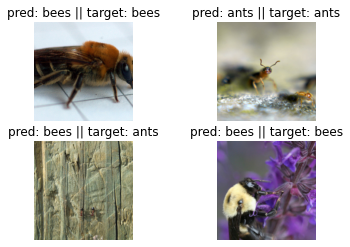

In [ ]:
visualize_predictions(pretrained_model)